In [1]:
import random
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                 download=False, 
                                 transform=transform, 
                                 train=True)

test_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                download=False, 
                                transform=transform, 
                                train=False)

random.seed(42)  
train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  
attack_loader = DataLoader(attack_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Original training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Attack samples: {len(attack_data)}")
print(f"Testing samples: {len(test_dataset)}")

Original training samples: 50000
Training samples after split: 45000
Attack samples: 5000
Testing samples: 10000


In [2]:
import torch.nn as nn

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

# ConvMixer model with hard-coded parameters
def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10     # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [3]:
import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/ConvModels/Base/ConvCifar.mod', weights_only=False, map_location="cuda:0")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


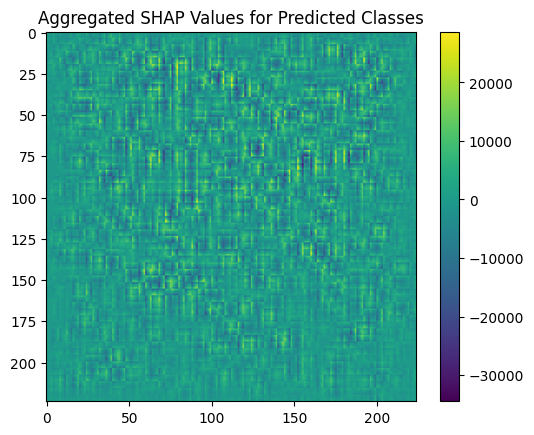

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load SHAP values
file_path = '/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Conv/ShapCifarConv.npy'
shap_values = np.load(file_path)  # Shape: (3, 224, 224, 10)


device = 'cuda'
model.eval()

# Initialize aggregated SHAP array
aggregated_shap_image = np.zeros((224, 224))

# Iterate through the attack_loader to compute predicted classes
for batch_images, _ in attack_loader:
    batch_images = batch_images.to(device)

    # Get model predictions
    outputs = model(batch_images)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (batch_size,)

    # Compute SHAP values for each image
    for i, predicted_class in enumerate(predicted_classes):
        # Aggregate SHAP values for the predicted class (sum over channels)
        class_shap_values = np.sum(shap_values[:, :, :, predicted_class], axis=0)  # Shape: (224, 224)
        aggregated_shap_image += class_shap_values

# Visualize the aggregated SHAP image
plt.imshow(aggregated_shap_image, cmap="viridis")
plt.title("Aggregated SHAP Values for Predicted Classes")
plt.colorbar()
plt.show()


In [5]:
# Flatten the array and find the indices of the top 22 values
flattened = aggregated_shap_image.flatten()
top_22_indices = np.argsort(flattened)[-22:][::-1]  # Indices of top 22 values, sorted descending

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_shap_image.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixels and their SHAP values
print("Top 22 Pixels and Their SHAP Values:")
for coord in top_22_coords:
    pixel_value = aggregated_shap_image[coord]
    print(f"Pixel {coord}: SHAP Value {pixel_value:.4f}")


Top 22 Pixels and Their SHAP Values:
Pixel (np.int64(32), np.int64(112)): SHAP Value 28650.6858
Pixel (np.int64(22), np.int64(79)): SHAP Value 28612.9505
Pixel (np.int64(29), np.int64(112)): SHAP Value 27986.5412
Pixel (np.int64(83), np.int64(152)): SHAP Value 27862.9560
Pixel (np.int64(30), np.int64(107)): SHAP Value 27420.8071
Pixel (np.int64(82), np.int64(152)): SHAP Value 27329.8406
Pixel (np.int64(72), np.int64(159)): SHAP Value 26988.3839
Pixel (np.int64(84), np.int64(147)): SHAP Value 26967.3707
Pixel (np.int64(115), np.int64(72)): SHAP Value 26410.9404
Pixel (np.int64(21), np.int64(79)): SHAP Value 26249.9588
Pixel (np.int64(103), np.int64(91)): SHAP Value 25459.5208
Pixel (np.int64(17), np.int64(192)): SHAP Value 25306.1685
Pixel (np.int64(28), np.int64(112)): SHAP Value 25202.9783
Pixel (np.int64(68), np.int64(131)): SHAP Value 25082.2042
Pixel (np.int64(78), np.int64(175)): SHAP Value 24805.8843
Pixel (np.int64(73), np.int64(180)): SHAP Value 24588.4188
Pixel (np.int64(31), 

In [7]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ConvShapCif/"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (from your output)
top_22_coords = [
    (32, 112), (22, 79), (29, 112), (83, 152), (30, 107),
    (82, 152), (72, 159), (84, 147), (115, 72), (21, 79),
    (103, 91), (17, 192), (28, 112), (68, 131), (78, 175),
    (73, 180), (31, 107), (74, 180), (134, 160), (16, 192),
    (20, 79), (111, 72)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

# Iterate through attack_loader and modify each image
for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone()  # Clone to avoid modifying the original dataset

    for img_idx, image_tensor in enumerate(batch_images):
        # Replace top pixel locations with black (0 value for all channels)
        for x, y in top_22_coords:
            image_tensor[:, x, y] = 0  # Set RGB channels to 0 at the specified location

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * len(batch_images) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")

Processed batch 1/79
Processed batch 2/79
Processed batch 3/79
Processed batch 4/79
Processed batch 5/79
Processed batch 6/79
Processed batch 7/79
Processed batch 8/79
Processed batch 9/79
Processed batch 10/79
Processed batch 11/79
Processed batch 12/79
Processed batch 13/79
Processed batch 14/79
Processed batch 15/79
Processed batch 16/79
Processed batch 17/79
Processed batch 18/79
Processed batch 19/79
Processed batch 20/79
Processed batch 21/79
Processed batch 22/79
Processed batch 23/79
Processed batch 24/79
Processed batch 25/79
Processed batch 26/79
Processed batch 27/79
Processed batch 28/79
Processed batch 29/79
Processed batch 30/79
Processed batch 31/79
Processed batch 32/79
Processed batch 33/79
Processed batch 34/79
Processed batch 35/79
Processed batch 36/79
Processed batch 37/79
Processed batch 38/79
Processed batch 39/79
Processed batch 40/79
Processed batch 41/79
Processed batch 42/79
Processed batch 43/79
Processed batch 44/79
Processed batch 45/79
Processed batch 46/